Personal start of this competition and notebook: 20/07/2022. You can find it here : https://www.kaggle.com/competitions/tabular-playground-series-jul-2022/overview

I particularly enjoyed this competition as it was the first clustering competition on kaggle. I was able to increase my knowledge on unsupervised learning and I learned new methods and algorithms like semi-supervised learning or the Bayesian Mixture Model algorithm. 
I was able to try out many of my ideas even if I didn't have time to test everything.
I finished 135th of this competition, putting knowledge and experience above ranking and its micro-optimizations for the moment!

Have a good read and don't hesitate to contact me if you have any advice to give or questions to ask. I can be reached on linkedIn : https://www.linkedin.com/in/yan-mazas-2b89371a3/

In [225]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn.preprocessing import RobustScaler,PowerTransformer, StandardScaler, MaxAbsScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklego.mixture import BayesianGMMClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.ensemble import GradientBoostingClassifier

In [41]:
datadeb = pd.read_csv(r"data.csv")

# Data Preparation

In [242]:
df = pd.DataFrame(datadeb)

In [43]:
df.isnull().sum()

id      0
f_00    0
f_01    0
f_02    0
f_03    0
f_04    0
f_05    0
f_06    0
f_07    0
f_08    0
f_09    0
f_10    0
f_11    0
f_12    0
f_13    0
f_14    0
f_15    0
f_16    0
f_17    0
f_18    0
f_19    0
f_20    0
f_21    0
f_22    0
f_23    0
f_24    0
f_25    0
f_26    0
f_27    0
f_28    0
dtype: int64

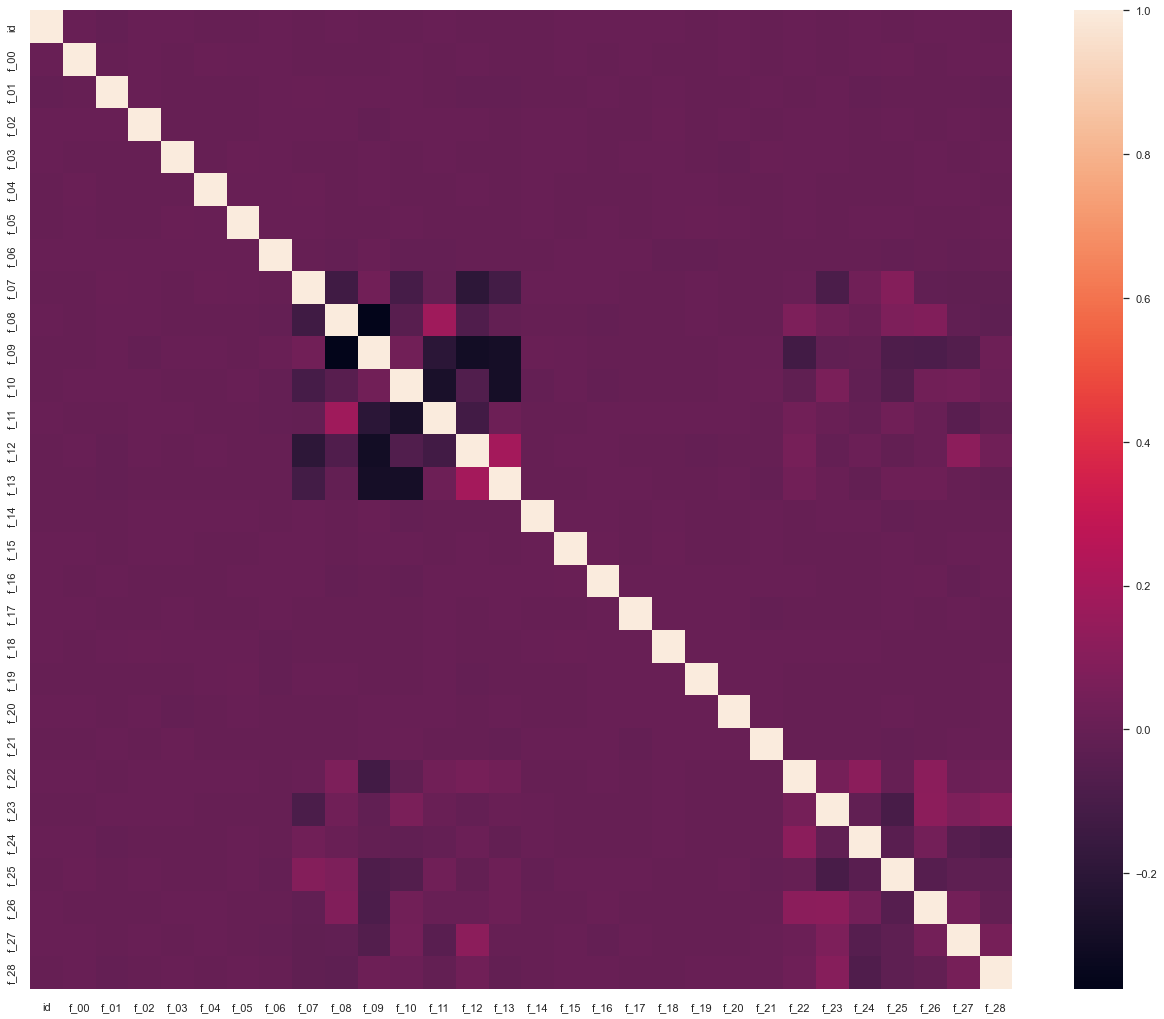

In [44]:
plt.figure(figsize=(22,18))
ax = sns.heatmap(df.corr(), annot=False)
plt.show()

We see that the data that are closest are 7 to 13 and 22 to 28. After several tests, these are the ones that contain information and are consistent for this clustering. Moreover, after a PCA, these are the most important data and for general algorithms, it is better to put only the really useful data.

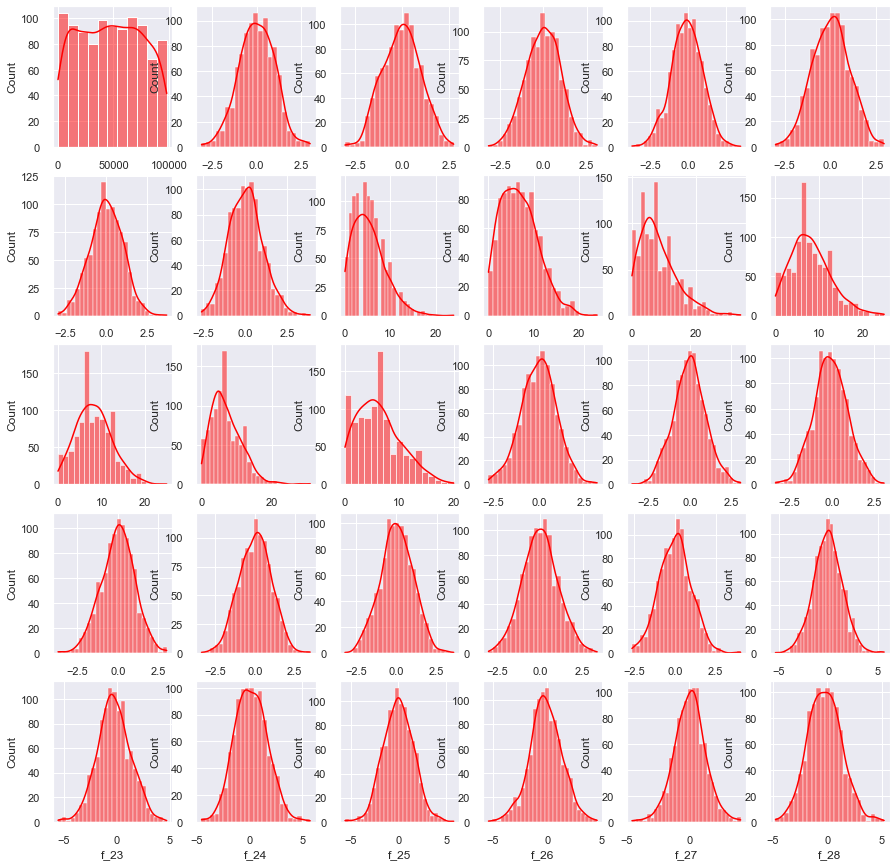

In [45]:
sns.set(rc={'figure.figsize':(15,15)})
for i, column in enumerate(list(df.columns), 1):
    plt.subplot(5,6,i)
    p=sns.histplot(x=column,data=df.sample(1000),stat='count',kde=True,color='red')
    


The data looks Gaussian. We will use powertransformer as a scaler. (plot found here : https://www.kaggle.com/code/azminetoushikwasi/clustering-techniques-algorithms-analysis)

# Les fonctions qui vont nous servir

### Data prep

In [348]:
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

In [46]:
def correlation(dataset, n):
    col = []
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > n:
                colname = corr_matrix.columns[i]
                if colname not in col :
                    col.append(colname)
    return col

In [47]:
def iqr_outliers(df,col_list):
    for col in col_list:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3-q1
        Lower_tail = q1 - 2 * iqr
        Upper_tail = q3 + 2 * iqr
        df.loc[df[col] > Upper_tail,col ]=Upper_tail
        df.loc[df[col] < Lower_tail,col]=Lower_tail
    return df

In [237]:
def scale(df):
    df= PowerTransformer().fit_transform(df)
    df= MinMaxScaler().fit_transform(df)
    return(df)

### Clustering

In [190]:
def Nombrecluster(df=df, between = (2,25), seed = 30):
    print('Elbow Method pour savoir le nombre de clusters que nous allons former:')
    Elbow_M = KElbowVisualizer(KMeans(random_state = seed), k=between)
    Elbow_M.fit(df)
    Elbow_M.show()

In [191]:
def K_Means(df = df, Ncluster = 7):
    kmeans = cluster.KMeans(n_clusters=Ncluster).fit_predict(df)
    return(kmeans)

In [361]:
def BGM(df = df, Ncluster = 7, N_iter = 1, max_iter = 10000, tol = 1e-6, n_init = 3, seed = 1):
    print("========================")
    print(f"C'est parti pour l'algorithme Bayesian Gaussian Mixture avec {Ncluster} clusters.")
    starttime = time.time()
    BGM = BayesianGaussianMixture(n_components = Ncluster,
                              covariance_type = 'full', 
                              max_iter = max_iter, 
                              random_state = seed, 
                              tol = tol,
                              init_params="kmeans",
                              n_init = N_iter)
    
    BGM.fit(df)
    y = BGM.predict(df)
    proba = np.max(BGM.predict_proba(df), axis=1) 
    deltat = time.time()-starttime
    minute = int(deltat//60)
    seconde = int(deltat%60)
    print(f"L'algorithme a duré {minute} minute(s) et {seconde} seconde(s)")
    print("========================")
    return(y, proba)

### BayesianGMM

In [297]:
def BayesianGMM(y, df = df, Ncluster = 7, seed = 1, N_iter = 1, max_iter = 500, tol = 1e-3, n_init = 3):
    
    print("========================")
    print(f"C'est parti pour {N_iter} itérations de l'algorithme BayesianGMM avec {Ncluster} clusters.")
    a=0
    for i in range(N_iter):
        
        print(f"===Itération numéro {i+1}===")
        
        starttime = time.time()
        
        bgm = BayesianGMMClassifier(
                n_components=Ncluster,
                random_state = seed,
                tol =tol,
                covariance_type = 'full',
                max_iter = max_iter,
                n_init=n_init,
                init_params='k-means++'
                         )
        bgm.fit(df, y)
        
        predict = bgm.predict(df)
    
        y = predict
        
        deltat = time.time()-starttime
        a+=deltat
        minute = int(deltat//60)
        seconde = int(deltat%60)
        
        print(f"L'itération numéro {i+1} est finie, elle a duré {minute} minute(s) et {seconde} seconde(s)")
    minute = int(a//60)
    seconde = int(a%60)

    proba = np.max(bgm.predict_proba(df), axis=1) 
    print("========================")
    print(f"La fonction a duré {minute} minute(s) et {seconde} seconde(s)")
    print("========================")
    return(y,proba)

### Apprentissage supervisé

In [194]:
def pourcentage(proba, seuil, size = df.shape[0]):
    new = pd.Series(proba)
    a = round(new[new>seuil].shape[0]/size*100,1)
    print(f"{a}% des probabilités sont supérieures a {seuil}")

In [ ]:
def KNN(y, proba, p = 0.8 , k_max = 50, df = df):
    y_s = y.copy()
    starttime = time.time()
    print("========================")
    print(f"C'est parti pour l'algorithme KNN pour trouver les clusters des données dont la probabilité d'appartenir à leur cluster actuel est infèrieure à {p}.")
    print("=== Choix de K === ")
    X_train, X_test, y_train, y_test = train_test_split(df[proba > p], y[proba > p], test_size=0.2)
    
    scores = []
    
    krange = range(1, k_max)
    
    for k in krange:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        scores.append(metrics.accuracy_score(y_test, y_pred))
    
    %matplotlib inline
    plt.plot(krange, scores)
    plt.xlabel("Valeur de k pour l'algorithme KNN")
    plt.ylabel('Test de la précision')

    n_neighbors = scores.index(max(scores)) + 1
    
    deltat = time.time()-starttime
    minute = int(deltat//60)
    seconde = int(deltat%60)
    
    print(f"Après {minute} minute(s) et {seconde} seconde(s), nous prenons donc k = {n_neighbors} ")
    starttime = time.time()
    print("=== Application de KNN ===")
    labelled_data = df[proba > p]
    unlabelled_data = df[~(proba > p)]
    
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(labelled_data, y[proba > p])
    
    y_s[~(proba > p)] = model.predict(unlabelled_data) 

    deltat = time.time()-starttime
    seconde = int(deltat)
    print(f"L'application de KNN a duré {seconde} seconde(s)")
    return(y_s)    

In [307]:
def GB(y, proba, p = 0.8 ,df = df, n_estimators=1000, learning_rate=0.1, max_depth=3, seed=1):
    y_s = y.copy()
    starttime = time.time()
    print("========================")
    print(f"C'est parti pour l'algorithme Gradient boosting pour trouver les clusters des données dont la probabilité d'appartenir à leur cluster actuel est infèrieure à {p} .")
    
    labelled_data = df[proba > p]
    unlabelled_data = df[~(proba > p)]
    
    model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=seed)
    model.fit(labelled_data, y[proba > p])
    
    y_s[~(proba > p)] = model.predict(unlabelled_data) 

    deltat = time.time()-starttime
    minute = int(deltat//60)
    seconde = int(deltat%60)
        
    print(f"L'application de Gradien Boosting a duré {minute} minute(s) et {seconde} seconde(s)")
    return(y_s)    

### PCA pour pouvoir visualiser les données

In [227]:
def PCA_3D(y = 'r', df = df):
    pca = PCA(n_components=3,random_state=1)
    pca.fit(df)
    PCA_ds = pd.DataFrame(pca.transform(df), columns=(["col1","col2","col3"]))
    PCA_ds.describe().T
    x =PCA_ds["col1"]
    y =PCA_ds["col2"]
    z =PCA_ds["col3"]

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(x,y,z, c=y, marker="." )
    ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
    plt.show()

# Data prep

In [243]:
correl = correlation(df, 0.09)
correl.append('f_07')
important_columns = correl
drop_cols=[col for col in df.columns if col not in important_columns]

df = df.drop(drop_cols,axis=1)

df = iqr_outliers(df,list(df.columns))

df = pd.DataFrame(scale(df))

# Clustering

How many clusters will we want to create?

Elbow Method pour savoir le nombre de clusters que nous allons former:


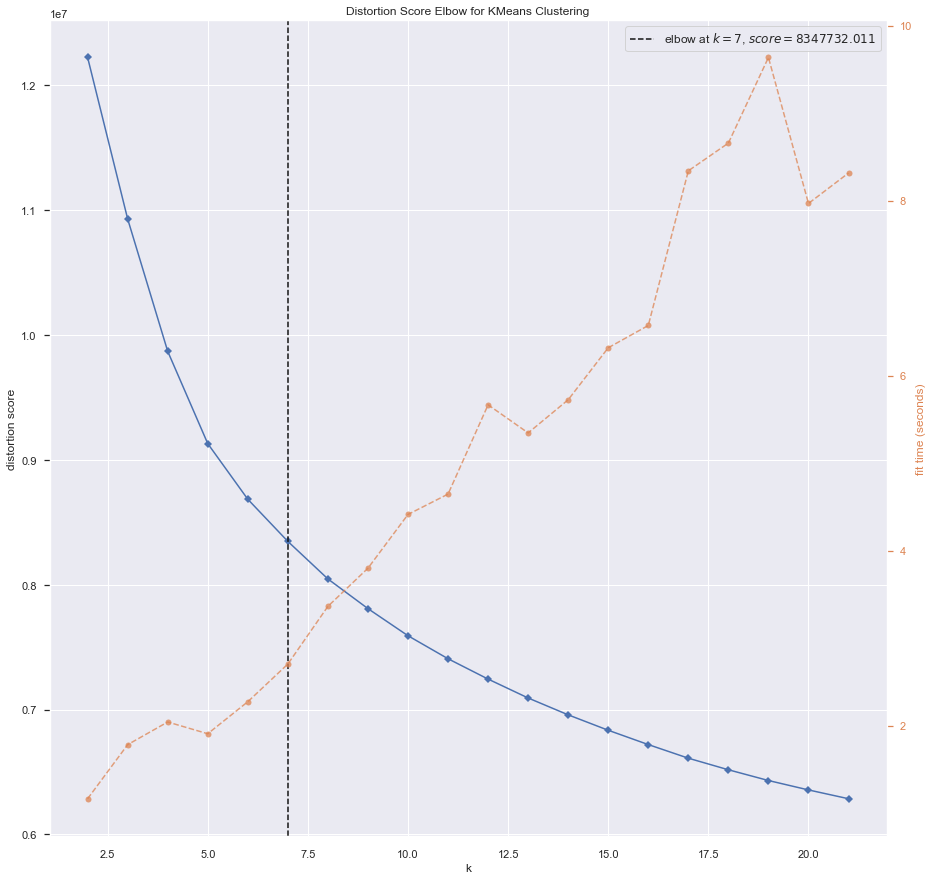

In [140]:
Nombrecluster(between = (2,22))

On prendra k = 7 durant la totalité du notebook

# KMeans + GMM + KNN

### KMeans

In [84]:
y_Kmeans = K_Means()

Score: 0.26251 ==> The Kmeans is not adapted, the clusters are potentially too much in "circle" as the kmeans wants. We will try to change this a little bit with BayesianGMM.

### GMM

In [105]:
y_Kmeans_GMM, proba_GMM = BayesianGMM(y_Kmeans, N_iter = 10)

10 itérations de l'algorithme BayesianGMM avec 7 clusters.
===Itération numéro 1===
L'itération numéro 1 est finie, elle a duré 5.0 minutes et 3.840850591659546 secondes
===Itération numéro 2===
L'itération numéro 2 est finie, elle a duré 3.0 minutes et 28.457504749298096 secondes
===Itération numéro 3===
L'itération numéro 3 est finie, elle a duré 2.0 minutes et 3.737034320831299 secondes
===Itération numéro 4===
L'itération numéro 4 est finie, elle a duré 2.0 minutes et 19.8371160030365 secondes
===Itération numéro 5===
L'itération numéro 5 est finie, elle a duré 37.0 minutes et 6.537283897399902 secondes
===Itération numéro 6===
L'itération numéro 6 est finie, elle a duré 0.0 minutes et 46.407840728759766 secondes
===Itération numéro 7===
L'itération numéro 7 est finie, elle a duré 1.0 minutes et 53.919883012771606 secondes
===Itération numéro 8===
L'itération numéro 8 est finie, elle a duré 2.0 minutes et 25.321638107299805 secondes
===Itération numéro 9===
L'itération numéro 9 est

With one iteration of this, we reach a score of: 0.28908.

In [147]:
pourcentage(proba_GMM, 0.90)

74.4% des probabilités sont supérieures a 0.9


C'est parti pour l'algorithme KNN pour trouver les clusters des données dont la probabilité d'appartenir à leur cluster actuel est infèrieure à 0.9 .
=== Choix de K === 
Après 407 secondes, nous prenons donc k = 11 
=== Application de KNN ===
L'application de KNN a duré 18 secondes


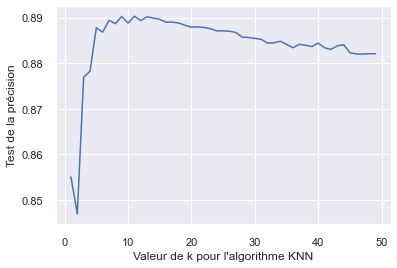

In [178]:
y_Kmeans_GMM_KNN = KNN(y_Kmeans_GMM, proba_GMM, p = 0.9)

The scores are low, one can assume that kmeans is not suitable since the real clusters must not be "balls" as kmeans wants them to be. Let's try something else.

# Bayesian Gaussian Mixture + GMM + KNN + GMM

### Bayesian Gaussian Mixture

In [148]:
y_BGM, proba_BGM = BGM()

C'est parti pour l'algorithme Bayesian Gaussian Mixture avec 7 clusters.
L'algorithme a duré 1.0 minutes et 43.259 secondes


The score after BGM is 0.60335

In [132]:
pourcentage(proba_BGM, 0.75)

69.1% des probabilités sont supérieures a 0.75


We will now only keep the clusters that have been chosen with a high probability and try to rework the others.

### GMM

In [160]:
y_BGM_GMM, proba_BGM_GMM = BayesianGMM(y_BGM, N_iter = 10)

C'est parti pour 10 itérations de l'algorithme BayesianGMM avec 7 clusters.
===Itération numéro 1===
L'itération numéro 1 est finie, elle a duré 2 minutes et 38 secondes
===Itération numéro 2===
L'itération numéro 2 est finie, elle a duré 1 minutes et 26 secondes
===Itération numéro 3===
L'itération numéro 3 est finie, elle a duré 1 minutes et 30 secondes
===Itération numéro 4===
L'itération numéro 4 est finie, elle a duré 1 minutes et 25 secondes
===Itération numéro 5===
L'itération numéro 5 est finie, elle a duré 1 minutes et 7 secondes
===Itération numéro 6===
L'itération numéro 6 est finie, elle a duré 0 minutes et 57 secondes
===Itération numéro 7===
L'itération numéro 7 est finie, elle a duré 0 minutes et 50 secondes
===Itération numéro 8===
L'itération numéro 8 est finie, elle a duré 1 minutes et 5 secondes
===Itération numéro 9===
L'itération numéro 9 est finie, elle a duré 1 minutes et 10 secondes
===Itération numéro 10===
L'itération numéro 10 est finie, elle a duré 1 minutes

In [171]:
pourcentage(proba_BGM_GMM, 0.95)

72.2% des probabilités sont supérieures a 0.95


C'est parti pour l'algorithme KNN pour trouver les clusters des données dont la probabilité d'appartenir à leur cluster actuel est infèrieure à 0.95 .
=== Choix de K === 
Après 6 minute(s) et 8 seconde(s), nous prenons donc k = 7 
=== Application de KNN ===
L'application de KNN a duré 17 seconde(s)


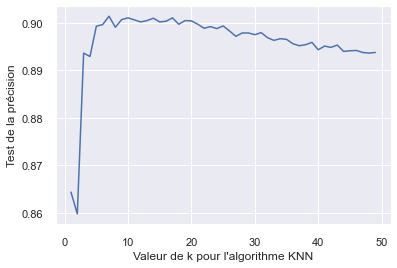

In [210]:
y_BGM_GMM_KNN = KNN(y_BGM_GMM, proba_BGM_GMM, p = 0.95)

With just clustering and KNN, we get a score of 0.62144. We now need to try other supervised learning methods and refine them. We will also add a GMM before and after semi-supervised learning.

In [211]:
y_BGM_GMM_KNN_GMM, proba_BGM_GMM_KNN_GMM = BayesianGMM(y_BGM_GMM_KNN, N_iter = 10)

C'est parti pour 10 itérations de l'algorithme BayesianGMM avec 7 clusters.
===Itération numéro 1===
L'itération numéro 1 est finie, elle a duré 1 minute(s) et 42 seconde(s)
===Itération numéro 2===
L'itération numéro 2 est finie, elle a duré 1 minute(s) et 10 seconde(s)
===Itération numéro 3===
L'itération numéro 3 est finie, elle a duré 0 minute(s) et 56 seconde(s)
===Itération numéro 4===
L'itération numéro 4 est finie, elle a duré 0 minute(s) et 59 seconde(s)
===Itération numéro 5===
L'itération numéro 5 est finie, elle a duré 0 minute(s) et 50 seconde(s)
===Itération numéro 6===
L'itération numéro 6 est finie, elle a duré 0 minute(s) et 50 seconde(s)
===Itération numéro 7===
L'itération numéro 7 est finie, elle a duré 1 minute(s) et 2 seconde(s)
===Itération numéro 8===
L'itération numéro 8 est finie, elle a duré 0 minute(s) et 48 seconde(s)
===Itération numéro 9===
L'itération numéro 9 est finie, elle a duré 0 minute(s) et 47 seconde(s)
===Itération numéro 10===
L'itération numér

In [214]:
sub = pd.read_csv(r"sample_submission.csv")
sub.Predicted = y_BGM_GMM_KNN_GMM
sub.to_csv("y_BGM_GMM_KNN_GMM.csv" ,index = False)

We now have a score of 0.77379, let's try another supervised learning method like gradient boosting

# Bayesian Gaussian Mixture + GMM + Gradien boosting + GMM

In [212]:
y_BGM_GMM_GB = GB(y_BGM_GMM, proba_BGM_GMM, p = 0.95)

C'est parti pour l'algorithme Gradient boosting pour trouver les clusters des données dont la probabilité d'appartenir à leur cluster actuel est infèrieure à 0.95 .
L'application de Gradien Boosting a duré 1752 seconde(s)


In [213]:
y_BGM_GMM_GB_GMM, proba_BGM_GMM_GB_GMM = BayesianGMM(y_BGM_GMM_GB, N_iter = 10)

C'est parti pour 10 itérations de l'algorithme BayesianGMM avec 7 clusters.
===Itération numéro 1===
L'itération numéro 1 est finie, elle a duré 1 minute(s) et 24 seconde(s)
===Itération numéro 2===
L'itération numéro 2 est finie, elle a duré 0 minute(s) et 59 seconde(s)
===Itération numéro 3===
L'itération numéro 3 est finie, elle a duré 0 minute(s) et 54 seconde(s)
===Itération numéro 4===
L'itération numéro 4 est finie, elle a duré 0 minute(s) et 51 seconde(s)
===Itération numéro 5===
L'itération numéro 5 est finie, elle a duré 1 minute(s) et 1 seconde(s)
===Itération numéro 6===
L'itération numéro 6 est finie, elle a duré 0 minute(s) et 51 seconde(s)
===Itération numéro 7===
L'itération numéro 7 est finie, elle a duré 0 minute(s) et 50 seconde(s)
===Itération numéro 8===
L'itération numéro 8 est finie, elle a duré 0 minute(s) et 50 seconde(s)
===Itération numéro 9===
L'itération numéro 9 est finie, elle a duré 0 minute(s) et 55 seconde(s)
===Itération numéro 10===
L'itération numér

In [215]:
sub.Predicted = y_BGM_GMM_GB_GMM
sub.to_csv("y_BGM_GMM_GB_GMM.csv" ,index = False)

My score is: 0.78806

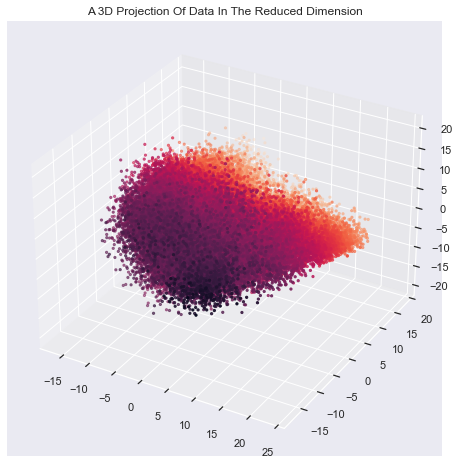

In [226]:
PCA_3D(y_BGM_GMM_GB_GMM)

# Deuxième partie, optimisation des methodes présentes et idées supplémentaires

This part is a catch-all where I put ideas that I might have had but didn't keep or didn't have time to continue during this competition.

My first idea is to make a PCA to keep only 16 or 17 data instead of keeping only 14 data and completely removing the others. This can allow adding information and not totally losing the features that are removed.

In [263]:
df2 = pd.DataFrame(datadeb)

In [351]:
df2 = df2.drop("id", axis = 1)

In [416]:
def PCA_df(df = df2, n_components = 14):
    pca = PCA(n_components=n_components,random_state=1)
    pca.fit(df)
    PCA_ds = pd.DataFrame(pca.transform(df))
    feature_imp = pca.components_
    for i in range(n_components):
        print("=================================")
        print(f"La donnée la plus utilisée pour la colonne {i+1} est la n°{np.where(feature_imp[i] == max(feature_imp[i]))[0][0]} avec un coefficient de valeur {max(feature_imp[i])}")

    return(PCA_ds)

### PCA

In [353]:
df_PCA = PCA_df(df2, n_components = 18)

La donnée la plus utilisée pour la colonne 1 est la n°9 avec une valeur de 0.824333553376711
La donnée la plus utilisée pour la colonne 2 est la n°10 avec une valeur de 0.7877496701261643
La donnée la plus utilisée pour la colonne 3 est la n°12 avec une valeur de 0.6035692914878348
La donnée la plus utilisée pour la colonne 4 est la n°7 avec une valeur de 0.817474128177713
La donnée la plus utilisée pour la colonne 5 est la n°12 avec une valeur de 0.5149157436353947
La donnée la plus utilisée pour la colonne 6 est la n°11 avec une valeur de 0.5333859647401777
La donnée la plus utilisée pour la colonne 7 est la n°7 avec une valeur de 0.4681086363734148
La donnée la plus utilisée pour la colonne 8 est la n°25 avec une valeur de 0.5665603639615657
La donnée la plus utilisée pour la colonne 9 est la n°24 avec une valeur de 0.6781919075573367
La donnée la plus utilisée pour la colonne 10 est la n°25 avec une valeur de 0.7325043203114322
La donnée la plus utilisée pour la colonne 11 est la n

### Scale

In [354]:
df_PCA = iqr_outliers(df_PCA,list(df.columns))

df_PCA = pd.DataFrame(scale(df_PCA))

### BGM

In [355]:
y_PCA_BGM, proba_PCA_BGM = BGM(df = df_PCA)

C'est parti pour l'algorithme Bayesian Gaussian Mixture avec 7 clusters.
L'algorithme a duré 1 minute(s) et 25 seconde(s)


### GMM

In [356]:
y_PCA_BGM_GMM, proba_PCA_BGM_GMM = BayesianGMM(y_PCA_BGM, df = df_PCA, N_iter = 10)

C'est parti pour 10 itérations de l'algorithme BayesianGMM avec 7 clusters.
===Itération numéro 1===
L'itération numéro 1 est finie, elle a duré 7 minute(s) et 55 seconde(s)
===Itération numéro 2===
L'itération numéro 2 est finie, elle a duré 3 minute(s) et 12 seconde(s)
===Itération numéro 3===
L'itération numéro 3 est finie, elle a duré 3 minute(s) et 8 seconde(s)
===Itération numéro 4===
L'itération numéro 4 est finie, elle a duré 2 minute(s) et 25 seconde(s)
===Itération numéro 5===
L'itération numéro 5 est finie, elle a duré 3 minute(s) et 3 seconde(s)
===Itération numéro 6===
L'itération numéro 6 est finie, elle a duré 2 minute(s) et 54 seconde(s)
===Itération numéro 7===
L'itération numéro 7 est finie, elle a duré 2 minute(s) et 32 seconde(s)
===Itération numéro 8===
L'itération numéro 8 est finie, elle a duré 3 minute(s) et 5 seconde(s)
===Itération numéro 9===
L'itération numéro 9 est finie, elle a duré 3 minute(s) et 5 seconde(s)
===Itération numéro 10===
L'itération numéro 1

In [357]:
pourcentage(proba_PCA_BGM_GMM, 0.8)

85.9% des probabilités sont supérieures a 0.8


### Gradient boosting

In [358]:
y_PCA_BGM_GMM_GB = GB(y_PCA_BGM_GMM, proba_PCA_BGM_GMM, df = df_PCA, p = 0.8)

C'est parti pour l'algorithme Gradient boosting pour trouver les clusters des données dont la probabilité d'appartenir à leur cluster actuel est infèrieure à 0.8 .
L'application de Gradien Boosting a duré 112 minute(s) et 57 seconde(s)


### GMM

In [359]:
y_PCA_BGM_GMM_GB_GMM, proba_PCA_BGM_GMM_GB_GMM = BayesianGMM(y_PCA_BGM_GMM_GB, df = df_PCA, N_iter = 10)

C'est parti pour 10 itérations de l'algorithme BayesianGMM avec 7 clusters.
===Itération numéro 1===
L'itération numéro 1 est finie, elle a duré 2 minute(s) et 25 seconde(s)
===Itération numéro 2===
L'itération numéro 2 est finie, elle a duré 2 minute(s) et 9 seconde(s)
===Itération numéro 3===
L'itération numéro 3 est finie, elle a duré 2 minute(s) et 25 seconde(s)
===Itération numéro 4===
L'itération numéro 4 est finie, elle a duré 2 minute(s) et 7 seconde(s)
===Itération numéro 5===
L'itération numéro 5 est finie, elle a duré 1 minute(s) et 57 seconde(s)
===Itération numéro 6===
L'itération numéro 6 est finie, elle a duré 1 minute(s) et 38 seconde(s)
===Itération numéro 7===
L'itération numéro 7 est finie, elle a duré 2 minute(s) et 1 seconde(s)
===Itération numéro 8===
L'itération numéro 8 est finie, elle a duré 2 minute(s) et 18 seconde(s)
===Itération numéro 9===
L'itération numéro 9 est finie, elle a duré 1 minute(s) et 45 seconde(s)
===Itération numéro 10===
L'itération numéro 

In [400]:
sub = pd.read_csv(r"sample_submission.csv")
sub.Predicted = y_PCA_BGM_GMM_GB_GMM
sub.to_csv("y_PCA18_BGM_GMM_GB_GMM.csv" ,index = False)

With 14 components in the PCA the score is: 0.49566
With 17, it is: 0.63251
With 18, it is: 0.74693
With 19 it is: 0.77379
With 20 it is: 0.63983

A new idea came to me but I didn't have time to do it properly: we have very close scores for a PCA of 17 and 18, why not try to merge these two cases by taking only the clusters where the proba is max between the two. Unfortunately, I didn't have time to implement this because many problems appeared to me. Indeed, the clusters are not really the same and so we can't identify them easily.

In [414]:
df_PCA = PCA_df(df2, n_components = 19)
df_PCA = iqr_outliers(df_PCA, list(df.columns))

df_PCA = pd.DataFrame(scale(df_PCA))

y_PCA19_BGM, proba_PCA19_BGM = BGM(df = df_PCA)

y_PCA19_BGM_GMM, proba_PCA19_BGM_GMM = BayesianGMM(y_PCA19_BGM, df = df_PCA, N_iter = 5)

pourcentage(proba_PCA19_BGM_GMM, 0.80)

y_PCA19_BGM_GMM_GB = GB(y_PCA19_BGM_GMM, proba_PCA19_BGM_GMM, df = df_PCA, p = 0.8)

y_PCA19_BGM_GMM_GB_GMM, proba_PCA19_BGM_GMM_GB_GMM = BayesianGMM(y_PCA19_BGM_GMM_GB, df = df_PCA, N_iter = 20)

La donnée la plus utilisée pour la colonne 1 est la n°9 avec une valeur de 0.8243335533768915
La donnée la plus utilisée pour la colonne 2 est la n°10 avec une valeur de 0.7877496701137481
La donnée la plus utilisée pour la colonne 3 est la n°12 avec une valeur de 0.6035692915611965
La donnée la plus utilisée pour la colonne 4 est la n°7 avec une valeur de 0.817474129471705
La donnée la plus utilisée pour la colonne 5 est la n°12 avec une valeur de 0.5149157433501582
La donnée la plus utilisée pour la colonne 6 est la n°11 avec une valeur de 0.5333859650901459
La donnée la plus utilisée pour la colonne 7 est la n°7 avec une valeur de 0.46810863349674414
La donnée la plus utilisée pour la colonne 8 est la n°25 avec une valeur de 0.5664199188730796
La donnée la plus utilisée pour la colonne 9 est la n°24 avec une valeur de 0.6781880383485213
La donnée la plus utilisée pour la colonne 10 est la n°25 avec une valeur de 0.7326999509271047
La donnée la plus utilisée pour la colonne 11 est la

In [415]:
sub = pd.read_csv(r"sample_submission.csv")
sub.Predicted = y_PCA19_BGM_GMM_GB_GMM
sub.to_csv("y_PCA19_BGM_GMM_GB_GMM.csv" ,index = False)

In [342]:
def maxprob(a, pa, b, pb):
    ordre = pa < pb
    a[ordre] = b[ordre]
    return a

In [388]:
from math import dist

In [411]:
def mapcluster(y1, y2, N_cluster = 7):
    center = [[],[]]
    for i in range(N_cluster):
        center[0].append(df_PCA[pd.DataFrame(y1)[0] == i].mean())
        center[1].append(df_PCA[pd.DataFrame(y2)[0] == i].mean())
    dict={}
    for i in range(N_cluster):
        m = dist(center[0][i], center[1][0])
        k = 0
        for j in range(1, N_cluster):
            p = dist(center[0][i], center[1][j])
            if p<m : 
                m = p
                k = j
        dict.update({i : k})
    return(dict)